## Reading Data from Sources and Process

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit,regexp_replace, col
from datetime import datetime, timedelta
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType
from pyspark.sql import Row
from pyspark.sql.functions import col,expr,format_number
from pyspark.sql.functions import col, lit, min

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Read CSV Example") \
    .getOrCreate()

df1 = spark.read.csv("daily_bist100/bist_live_2024-03-28.csv", header=True, inferSchema=True)
df1 = df1.withColumn('18:00', df1['17:00'])

df2 = spark.read.csv("daily_bist100/bist_live_2024-03-27.csv", header=True, inferSchema=True)
df2 = df2.withColumn('17:00', df2['16:00'])
df2 = df2.withColumn('18:00', df2['16:00'])

df1 = df1.withColumn('Date', lit('2024-03-28'))
df2 = df2.withColumn('Date', lit('2024-03-27'))

df3 = spark.read.csv("daily_bist100/bist_live_2024-03-26.csv", header=True, inferSchema=True)
df3 = df3.withColumn('Date', lit('2024-03-26'))

df4 = spark.read.csv("daily_bist100/bist_live_2024-03-29.csv", header=True, inferSchema=True)
df4 = df4.withColumn('Date', lit('2024-03-29'))

union_df = df1.union(df2).union(df3).union(df4)

melted_df = union_df.selectExpr("stock_name", "Date","stack(8, '10:00', `10:00`, '11:00', `11:00`, '12:00', `12:00`, '13:00', `13:00`, '14:00', `14:00`, '15:00', `15:00`, '16:00', `16:00`, '17:00', `17:00`) as (hour, value)")

stock_stats_df = melted_df.groupBy("stock_name","Date").agg(
    expr("min(value) as min_value"),
    expr("max(value) as max_value"),
    format_number(expr("avg(value)"), 2).alias("avg_value"),
    format_number(expr("stddev(value)"), 2).alias("std_value")
)
output_path = 'union_df.parquet'
#stock_stats_df.write.parquet('new_parquet1')
df_single_partition = union_df.coalesce(1)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, regexp_replace, col
from datetime import datetime, timedelta
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Read Comments Data") \
    .getOrCreate()

# Calculate the date for yesterday
todate = '2024-03-29'

days = [
    datetime.strptime(todate, '%Y-%m-%d').date(),
    datetime.strptime(todate, '%Y-%m-%d').date() - timedelta(1),
    datetime.strptime(todate, '%Y-%m-%d').date() - timedelta(2),
    datetime.strptime(todate, '%Y-%m-%d').date() - timedelta(3)
]

schema_comments = StructType([
    StructField("Stock", StringType(), True),
    StructField("User", StringType(), True),
    StructField("Comment", StringType(), True),
    StructField("Comment Time", StringType(), True),  # Change StringType to DateType
    StructField("Date", DateType(), True)
])

comments_df = spark.createDataFrame([], schema_comments)

for i in days:
    comments_path = f"daily_comments/{i}/bist_comments_{i}.json"


    df = spark.read \
        .option("multiline", "true") \
        .schema(schema_comments) \
        .json(comments_path)
    comments_df = comments_df.union(df)

comments_df = comments_df.drop('Comment Time', 'User')

rdd = comments_df.rdd.map(lambda x: ((x['Stock'], x['Date']), 1)) \
                     .reduceByKey(lambda x, y: x + y) \
                     .map(lambda x: (x[0][0], x[0][1], x[1]))


rdd2 = comments_df.rdd.map(lambda x: (x['Comment']))

top_comments = rdd.filter(lambda x: x[1] == todate).sortBy(lambda x: x[2],ascending = False)
top_5_elements = top_comments.take(5)

# Extracting comments
comments_rdd = comments_df.rdd.map(lambda x: x['Comment'].lower().split())

# Filter out stop words
turkish_stop_words = ['acaba', 'ama', 'aslında', 'az', 'bazı', 'belki', 'biri', 'birkaç', 'birşey', 'biz', 'bu',
                      'çok', 'çünkü', 'da', 'daha', 'de', 'defa', 'diye', 'eğer', 'en', 'gibi', 'hem', 'hep',
                      'hepsi', 'her', 'hiç', 'için', 'ile', 'ise', 'kez', 'ki', 'kim', 'mı', 'mu', 'mü', 'nasıl',
                      'ne', 'neden', 'nerde', 'nerede', 'nereye', 'niçin', 'niye', 'o', 'sanki', 'şey', 'siz', 'şu',
                      'tüm', 've', 'veya', 'ya', 'yani','bir','var','cok','mi','kadar','bi','1','2','3','e','a','5','10']
filtered_comments_rdd = comments_rdd.map(lambda words: [word for word in words if word not in turkish_stop_words])

# Count word occurrences
word_counts = filtered_comments_rdd.flatMap(lambda words: [(word, 1) for word in words]) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda x: x[1], ascending=False) \
    .collect()

# Convert RDD to DataFrame
count_df = spark.createDataFrame(rdd, ['Stock', 'Date', 'CommentCount']).orderBy('Date','CommentCount',ascending=False)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit,regexp_replace, col
from datetime import datetime, timedelta
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Read JSON Data") \
    .getOrCreate()

# Calculate the date for yesterday
todate = '2024-03-29'

days = [
    datetime.strptime(todate, '%Y-%m-%d').date(),
    datetime.strptime(todate, '%Y-%m-%d').date() - timedelta(1),
    datetime.strptime(todate, '%Y-%m-%d').date() - timedelta(2),
    datetime.strptime(todate, '%Y-%m-%d').date() - timedelta(3)
]
spark = SparkSession.builder \
    .appName("Empty DataFrame Creation") \
    .getOrCreate()

schema_analysis = StructType([
    StructField("comment", StringType(), True),
    StructField("date", DateType(), True),
    StructField("disc_index", IntegerType(), True),
    StructField("ticker", StringType(), True)
])

analysis_df = spark.createDataFrame([], schema_analysis)


for i in days:
    analysis_path = f"analysis_results/{i}/analysis_results_{i}.json"

    df = spark.read \
        .option("multiline", "true") \
        .json(analysis_path)
    analysis_df = analysis_df.union(df)

schema_statement = StructType([
    StructField("company_name", StringType(), True),
    StructField("disc_index", IntegerType(), True),
    StructField("text", StringType(), True)
])

statement_df = spark.createDataFrame([], schema_statement)
for i in days:
    statement_path = f"statement_output/{i}/statement_{i}.json"

    df = spark.read \
        .option("multiline", "true") \
        .json(statement_path)
    statement_df = statement_df.union(df)


joined_df = analysis_df.join(statement_df, analysis_df['disc_index'] == statement_df['disc_index'], "inner")
joined_df = joined_df.drop('ticker')

rdd = joined_df.rdd

def replace_newline(row):
    row_dict = row.asDict()
    row_dict['comment'] = row_dict['comment'].replace("\n", "")
    return row_dict

# Apply the function to each row of the RDD
new_rdd = rdd.map(replace_newline)

new_rdd2 = new_rdd.map(lambda x: ((x['company_name'], x['date']), 1)) \
                 .reduceByKey(lambda x, y: x + y) \
                 .map(lambda x: (x[0][0], x[0][1], x[1]))

count_df = spark.createDataFrame(new_rdd2, schema=['company_name','date','count'])

# Convert the resulting RDD back to a DataFrame
new_df = spark.createDataFrame(new_rdd, schema=joined_df.schema)

In [2]:
from pyspark.sql.functions import rand, when

df2=new_df.select('date', 'company_name').dropDuplicates()
stock_stats_df=stock_stats_df.withColumnRenamed('Date','date')
stock_stats_df=stock_stats_df.withColumnRenamed('stock_name','company_name')
df3 = df2.withColumn("sentiment", when(rand() > 0.5, 1).otherwise(0))

df3.show()
count_df.show()
stock_stats_df.show()

+----------+------------+---------+
|      date|company_name|sentiment|
+----------+------------+---------+
|2024-03-28|       DOHOL|        0|
|2024-03-27|       IZENR|        1|
|2024-03-29|       EREGL|        0|
|2024-03-29|       IZENR|        1|
|2024-03-27|       ASELS|        0|
|2024-03-26|       ISGYO|        0|
|2024-03-26|        SISE|        0|
|2024-03-28|        SISE|        1|
|2024-03-29|       KOZAL|        1|
|2024-03-29|       AHGAZ|        0|
|2024-03-29|       ISMEN|        0|
|2024-03-26|       ASELS|        1|
|2024-03-29|       QUAGR|        1|
|2024-03-28|       VESTL|        0|
|2024-03-27|       GARAN|        1|
|2024-03-28|       SMRTG|        1|
|2024-03-29|       TAVHL|        1|
|2024-03-28|       PGSUS|        0|
|2024-03-27|       ALBRK|        1|
|2024-03-27|       GESAN|        0|
+----------+------------+---------+
only showing top 20 rows

+------------+----------+-----+
|company_name|      date|count|
+------------+----------+-----+
|       ISMEN|

In [3]:
from pyspark.sql.functions import col

merged_df = stock_stats_df.join(count_df, ["company_name", "date"],'left').join(df3,["company_name", "date"] , "left")

# Clean up null values or fill them with an appropriate value
merged_df = merged_df.fillna({
    "sentiment": 0.0,
    "count": 0.0,
    "avg_value": 0.0,
    "std_value": 0.0,
    "max_value": 0.0,
    "min_value": 0.0
})

merged_df.show()

+------------+----------+---------+---------+---------+---------+-----+---------+
|company_name|      date|min_value|max_value|avg_value|std_value|count|sentiment|
+------------+----------+---------+---------+---------+---------+-----+---------+
|       KAYSE|2024-03-28|    28.94|    29.22|    29.08|     0.09|    0|        0|
|       GWIND|2024-03-28|     24.8|    25.06|    24.91|     0.09|    1|        1|
|       EUREN|2024-03-28|     15.2|    16.37|    15.97|     0.39|    0|        0|
|        SOKM|2024-03-28|    58.25|     58.5|    58.38|     0.10|    1|        1|
|       EKGYO|2024-03-28|     9.44|     9.68|     9.61|     0.08|    4|        0|
|       PENTA|2024-03-28|    18.22|    18.42|    18.30|     0.06|    5|        0|
|       ALFAS|2024-03-28|     88.0|     88.9|    88.36|     0.34|    0|        0|
|        DOAS|2024-03-28|    309.5|    313.0|   310.47|     1.24|    0|        0|
|       ISGYO|2024-03-28|    14.36|    14.58|    14.51|     0.07|    1|        1|
|        MAVI|20

## Feature Engineering

In [4]:
from pyspark.sql.functions import col, avg, stddev
from pyspark.sql.window import Window

# Convert the 'avg_value' and 'std_value' columns to float
merged_df = merged_df.withColumn("avg_value", col("avg_value").cast("float"))
merged_df = merged_df.withColumn("std_value", col("std_value").cast("float"))

# Calculate the moving average and standard deviation (e.g., 5-day)
windowSpec = Window.partitionBy("company_name").orderBy("date").rowsBetween(-4, 0)

merged_df = merged_df.withColumn("moving_avg", avg("avg_value").over(windowSpec))
merged_df = merged_df.withColumn("moving_std", stddev("avg_value").over(windowSpec))

merged_df.show()

+------------+----------+---------+---------+---------+---------+-----+---------+------------------+-------------------+
|company_name|      date|min_value|max_value|avg_value|std_value|count|sentiment|        moving_avg|         moving_std|
+------------+----------+---------+---------+---------+---------+-----+---------+------------------+-------------------+
|       AEFES|2024-03-26|    145.2|    149.7|   147.35|     1.73|   10|        1|147.35000610351562|               NULL|
|       AEFES|2024-03-27|    146.0|    150.9|   149.06|     1.55|    0|        0| 148.2050018310547| 1.2091465536567938|
|       AEFES|2024-03-28|    147.7|    151.0|   149.43|     0.99|    0|        0|148.61333211263022| 1.1096028797117838|
|       AEFES|2024-03-29|    151.2|    152.5|   151.89|     0.53|    0|        0|149.43249893188477| 1.8721510297463417|
|       AGHOL|2024-03-26|    250.3|    255.3|   252.02|     1.84|   11|        1|252.02000427246094|               NULL|
|       AGHOL|2024-03-27|   252.

In [5]:
# Clean up null values or fill them with an appropriate value
merged_df = merged_df.fillna({
    "sentiment": 0.0,
    "count": 0.0,
    "avg_value": 0.0,
    "std_value": 0.0,
    "moving_avg": 0.0,
    "moving_std": 0.0
})

## Linear Regression

In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Create a feature vector
feature_cols = ["sentiment", "count", "avg_value", "std_value", "moving_avg", "moving_std"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(merged_df)

# Split train-test data
train_data = data.filter(col("date").isin("2024-03-28", "2024-03-27", "2024-03-26"))
test_data = data.filter(col("date") == "2024-03-29")

# Traing data
lr = LinearRegression(labelCol="avg_value", featuresCol="features")
model = lr.fit(train_data)

# Predict with test data
predictions = model.transform(test_data)
predictions.show()

+------------+----------+---------+---------+---------+---------+-----+---------+------------------+-------------------+--------------------+------------------+
|company_name|      date|min_value|max_value|avg_value|std_value|count|sentiment|        moving_avg|         moving_std|            features|        prediction|
+------------+----------+---------+---------+---------+---------+-----+---------+------------------+-------------------+--------------------+------------------+
|       AEFES|2024-03-29|    151.2|    152.5|   151.89|     0.53|    0|        0|149.43249893188477| 1.8721510297463417|[0.0,0.0,151.8899...| 151.8899993896502|
|       AGHOL|2024-03-29|    268.5|    273.0|    270.0|      1.4|    0|        0| 262.3325004577637|  8.051587793239039|[0.0,0.0,270.0,1....| 270.0000000000022|
|       AHGAZ|2024-03-29|    13.21|     13.5|    13.31|      0.1|    1|        0|13.102500200271606|0.24046855210179982|[0.0,1.0,13.31000...| 13.31000041961689|
|       AKBNK|2024-03-29|    46.58

In [14]:
print(model.coefficients)
print(model.intercept)

[4.860686156809454e-13,-8.969246583582371e-14,1.0000000000012719,-1.572116976188748e-15,-1.269359407649007e-12,-1.045250776589221e-12]
2.3320834992505314e-13


In [17]:
intercept = model.intercept
coefficients = model.coefficients

lr_function = f"y = {intercept:.20f}"
for i, coef in enumerate(coefficients):
    lr_function += f" + {coef:.20f} * {feature_cols[i]}"

print(lr_function)


y = 0.00000000000023320835 + 0.00000000000048606862 * sentiment + -0.00000000000008969247 * count + 1.00000000000127187150 * avg_value + -0.00000000000000157212 * std_value + -0.00000000000126935941 * moving_avg + -0.00000000000104525078 * moving_std


In [18]:
from pyspark.sql.functions import when

# Generate buy/sell signals based on predictions
predictions = predictions.withColumn("signal", when(col("prediction") > col("avg_value"), "buy").otherwise("sell"))
predictions.select("company_name", "date", "avg_value", "prediction", "signal").show()

+------------+----------+---------+------------------+------+
|company_name|      date|avg_value|        prediction|signal|
+------------+----------+---------+------------------+------+
|       AEFES|2024-03-29|   151.89| 151.8899993896502|   buy|
|       AGHOL|2024-03-29|    270.0| 270.0000000000022|   buy|
|       AHGAZ|2024-03-29|    13.31| 13.31000041961689|   buy|
|       AKBNK|2024-03-29|    46.96| 46.95999908447367|   buy|
|       AKCNS|2024-03-29|   145.62|145.61999511718963|   buy|
|       AKFYE|2024-03-29|    22.37|22.370000839232294|  sell|
|        AKSA|2024-03-29|    99.96| 99.95999908447426|   buy|
|       AKSEN|2024-03-29|    34.69|34.689998626709425|   buy|
|       ALARK|2024-03-29|   131.06|131.05999755859457|   buy|
|       ALBRK|2024-03-29|     4.34| 4.340000152588143|   buy|
|       ALFAS|2024-03-29|    91.11| 91.11000061035294|   buy|
|       ARCLK|2024-03-29|   146.89|146.88999938964827|  sell|
|       ASELS|2024-03-29|    55.96|55.959999084472834|   buy|
|       

In [30]:
evaluation = model.evaluate(test_data)
r2 = evaluation.r2
mse = evaluation.meanSquaredError

print(f"R²: {r2}")
print(f"MSE: {mse}")

R²: 1.0
MSE: 5.209508589721286e-24


## Random Forest

In [27]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, when

spark = SparkSession.builder.appName("RandomForestExample").getOrCreate()

# Create a feature vector
feature_cols = ["sentiment", "count", "avg_value", "std_value", "moving_avg", "moving_std"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
data = assembler.transform(merged_df)

# Split train-test data
train_data = data.filter(col("date").isin("2024-03-28", "2024-03-27", "2024-03-26"))
test_data = data.filter(col("date") == "2024-03-29")

# Create RandomForestRegressor
rf = RandomForestRegressor(labelCol="avg_value", featuresCol="features", numTrees=50)
rf_model = rf.fit(train_data)

# Predict with test data
predictions = rf_model.transform(test_data)

R²: 0.9501973300984787
Mean Squared Error: 1361.4652847968664


In [28]:
evaluator = RegressionEvaluator(labelCol="avg_value", predictionCol="prediction")

r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R²: {r2}")

mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
print(f"Mean Squared Error: {mse}")

R²: 0.9501973300984787
Mean Squared Error: 1361.4652847968664


In [103]:
threshold = predictions["avg_value"]
# Generate buy/sell signals based on predictions
predictions = predictions.withColumn("buy_sell", when(col("prediction") > threshold, "buy").otherwise("sell"))

final_output = predictions.select("company_name", "date","avg_value", "prediction", "buy_sell")
final_output.filter(col('date')=='2024-03-29').show(n=50)

+------------+----------+---------+------------------+--------+
|company_name|      date|avg_value|        prediction|buy_sell|
+------------+----------+---------+------------------+--------+
|       AEFES|2024-03-29|   151.89| 139.7701252022088|    sell|
|       AGHOL|2024-03-29|    270.0| 273.1653439345861|     buy|
|       AHGAZ|2024-03-29|    13.31|14.073583322734056|     buy|
|       AKBNK|2024-03-29|    46.96|  57.4738322724093|     buy|
|       AKCNS|2024-03-29|   145.62|133.39976449548396|    sell|
|       AKFYE|2024-03-29|    22.37|  21.9254539572418|    sell|
|        AKSA|2024-03-29|    99.96|120.47336330072046|     buy|
|       AKSEN|2024-03-29|    34.69| 32.96259442543558|    sell|
|       ALARK|2024-03-29|   131.06|105.12776636663594|    sell|
|       ALBRK|2024-03-29|     4.34|12.661887912240331|     buy|
|       ALFAS|2024-03-29|    91.11|108.00904520062949|     buy|
|       ARCLK|2024-03-29|   146.89| 152.4211131830178|     buy|
|       ASELS|2024-03-29|    55.96|60.62

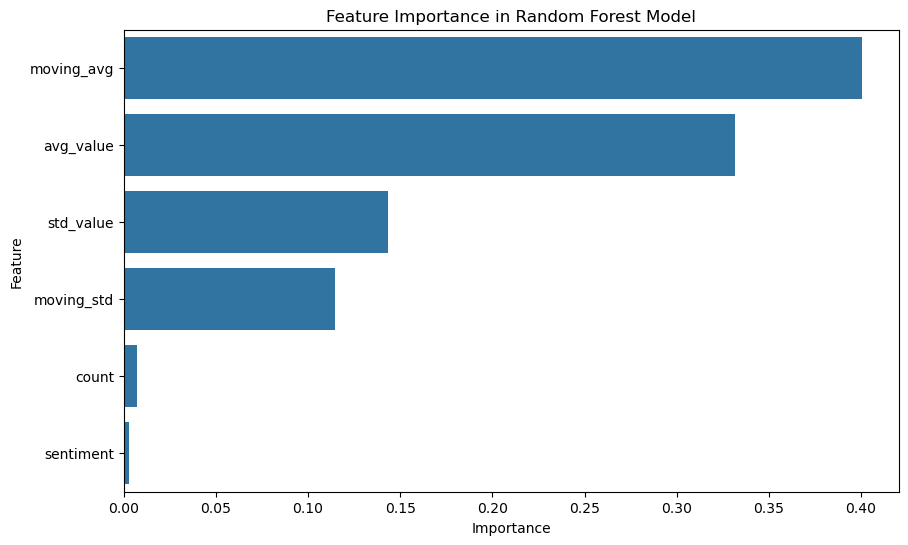

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Feature Importance
importances = rf_model.featureImportances
features = feature_cols

# Visualize the importance of features."
importance_dict = dict(zip(features, importances))
importance_df = pd.DataFrame(list(importance_dict.items()), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title('Feature Importance in Random Forest Model')
plt.show()